In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.dates import HourLocator
import cmaps
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Apple Symbols'   
plt.rcParams['axes.unicode_minus'] = False      

In [2]:
# 读取数据
df = pd.read_excel('Prediction_data.xlsx',0)

In [3]:

df1 = df[df['光伏电站编号']==1001]
df1[df1.duplicated()]

,光伏电站编号,时间,功率,气象站编号,总辐照度,法向辐照度,散射辐照度,气温,光板温度,湿度
1093,1001,2019-06-24 03:00:00,0.0000,104000001,0.00,0.00,0.00,22.69,21.51,76.14
1099,1001,2019-06-24 05:00:00,0.0000,104000001,0.00,0.00,0.00,21.73,20.51,83.78
1102,1001,2019-06-24 06:00:00,62.0627,104000001,68.32,58.99,16.10,21.56,20.64,87.08
1105,1001,2019-06-24 07:00:00,233.6296,104000001,259.84,224.37,47.16,22.86,23.46,84.36
1110,1001,2019-06-24 09:00:00,681.6218,104000001,664.42,573.73,122.96,25.36,32.94,77.05
1188,1001,2019-06-26 00:00:00,0.0000,104000001,0.00,0.00,0.00,23.50,22.24,89.80
3827,1001,2019-08-26 00:00:00,0.0000,104000001,0.00,0.00,0.00,27.44,26.46,93.75
3841,1001,2019-08-26 05:00:00,0.0000,104000001,0.00,0.00,0.00,26.87,26.00,95.96
3845,1001,2019-08-26 06:00:00,13.3617,104000001,23.26,20.09,6.35,27.00,26.29,96.21


In [4]:
# 1002光伏电站的重复行
df2 = df[df['光伏电站编号']==1002]
df2[df2.duplicated()]

,光伏电站编号,时间,功率,气象站编号,总辐照度,法向辐照度,散射辐照度,气温,光板温度,湿度
1088,1002,2019-06-24 01:00:00,0.0,104000002,0.0,0.0,0.0,21.1,0.0,92.7
1091,1002,2019-06-24 02:00:00,0.0,104000002,0.0,0.0,0.0,22.1,0.0,83.2
1097,1002,2019-06-24 04:00:00,0.0,104000002,0.0,0.0,0.0,21.1,0.0,89.4
1142,1002,2019-06-25 00:00:00,0.0,104000002,0.0,0.0,0.0,22.9,0.0,84.3
1333,1002,2019-06-29 00:00:00,0.0,104000002,0.0,0.0,0.0,28.3,0.0,84.7
1381,1002,2019-06-30 00:00:00,0.0,104000002,0.0,0.0,0.0,25.5,0.0,96.6
3831,1002,2019-08-26 01:00:00,0.0,104000002,0.0,0.0,0.0,26.9,0.0,94.8
3834,1002,2019-08-26 02:00:00,0.0,104000002,0.0,0.0,0.0,26.7,0.0,95.8
3839,1002,2019-08-26 04:00:00,0.0,104000002,0.0,0.0,0.0,26.9,0.0,95.2
3843,1002,2019-08-26 05:00:00,0.0,104000002,0.0,0.0,0.0,27.1,0.0,94.0


In [5]:
# 去除重复行并重新拼接
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()
df = pd.concat([df1,df2]).reset_index(drop=True)

In [6]:
# 查看光伏电站编号
df['光伏电站编号'].unique()

array([1001, 1002])

In [7]:
# 增加月列
df['月'] = df['时间'].dt.month
# 增加日列
df['日'] = df['时间'].dt.day
# 增加小时列
df['时'] = df['时间'].dt.hour 

# 删除气象站编号（因为和光伏站是对应的，不必重复）
del df['气象站编号']


In [8]:
# 筛选出功率为0的行
zero_power = df[df['功率']==0]


In [9]:
# 分别绘制6月14日两个光伏电站的功率变化曲线
data = df[df['时间'].isin(pd.date_range(start='2019-06-14 00:00:00',end='2019-06-14 23:00:00',freq='1H'))]
time1 = data[data['光伏电站编号']==1001]['时间']
power1 = data[data['光伏电站编号']==1001]['功率']
time2 = data[data['光伏电站编号']==1002]['时间']
power2 = data[data['光伏电站编号']==1002]['功率']


In [10]:
# （原始数据）绘制两个电站在6、7、8月的日变化曲线
data1 = df[df['光伏电站编号']==1001].set_index('时间')
data2 = df[df['光伏电站编号']==1002].set_index('时间')

In [11]:
June = pd.date_range(start='2019-06-01',end='2019-06-30')
July = pd.date_range(start='2019-07-01',end='2019-07-31')
August = pd.date_range(start='2019-08-01',end='2019-08-30')

In [12]:
# 删除缺失值并确保无缺失值
df.dropna(axis=0,inplace=True)
df['功率'].isna().sum()/df.shape[0]*100

0.0

In [13]:
# （原始数据）绘制两个电站在6、7、8月的日变化曲线
data1 = df[df['光伏电站编号']==1001].set_index('时间')
data2 = df[df['光伏电站编号']==1002].set_index('时间')

In [14]:
# 我们来比较一下两个光伏电站的异同
time1 = df[df['光伏电站编号']==1001]['时间']
time2 = df[df['光伏电站编号']==1002]['时间']
var_list = ['总辐照度','法向辐照度','散射辐照度','气温','光板温度','湿度']


In [15]:
import seaborn as sns

sns.set(font='Apple Symbols')

In [16]:
import numpy as np
# 计算相关系数
def cal_corr(x, y, **kwargs):
    coef = np.corrcoef(x, y)[0][1]
    label = r'$\rho$ = ' + str(round(coef, 3))
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.9), size = 15, xycoords = ax.transAxes)

# 显示详细信息
def show_summary(x, **kwargs):
    mean = np.mean(x)
    std = np.std(x)
    min_ = np.min(x)
    p_25 = np.percentile(x, 25)
    p_50 = np.percentile(x, 50)
    p_75 = np.percentile(x, 75)
    max_ = np.max(x)
    label = "mean: %s\nstd: %s\nmin_: %s\np_25: %s\np_50: %s\np_75: %s\nmax_: %s\n" %(str(round(mean, 3)), str(round(std, 3)),str(round(min_, 3)),str(round(p_25, 3)),str(round(p_50, 3)),str(round(p_75, 3)),str(round(max_, 3)))
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.05), size = 15, xycoords = ax.transAxes)

In [17]:
data = df[df['光伏电站编号']==1001]
del data['光伏电站编号']
corrMatrix = data.corr()

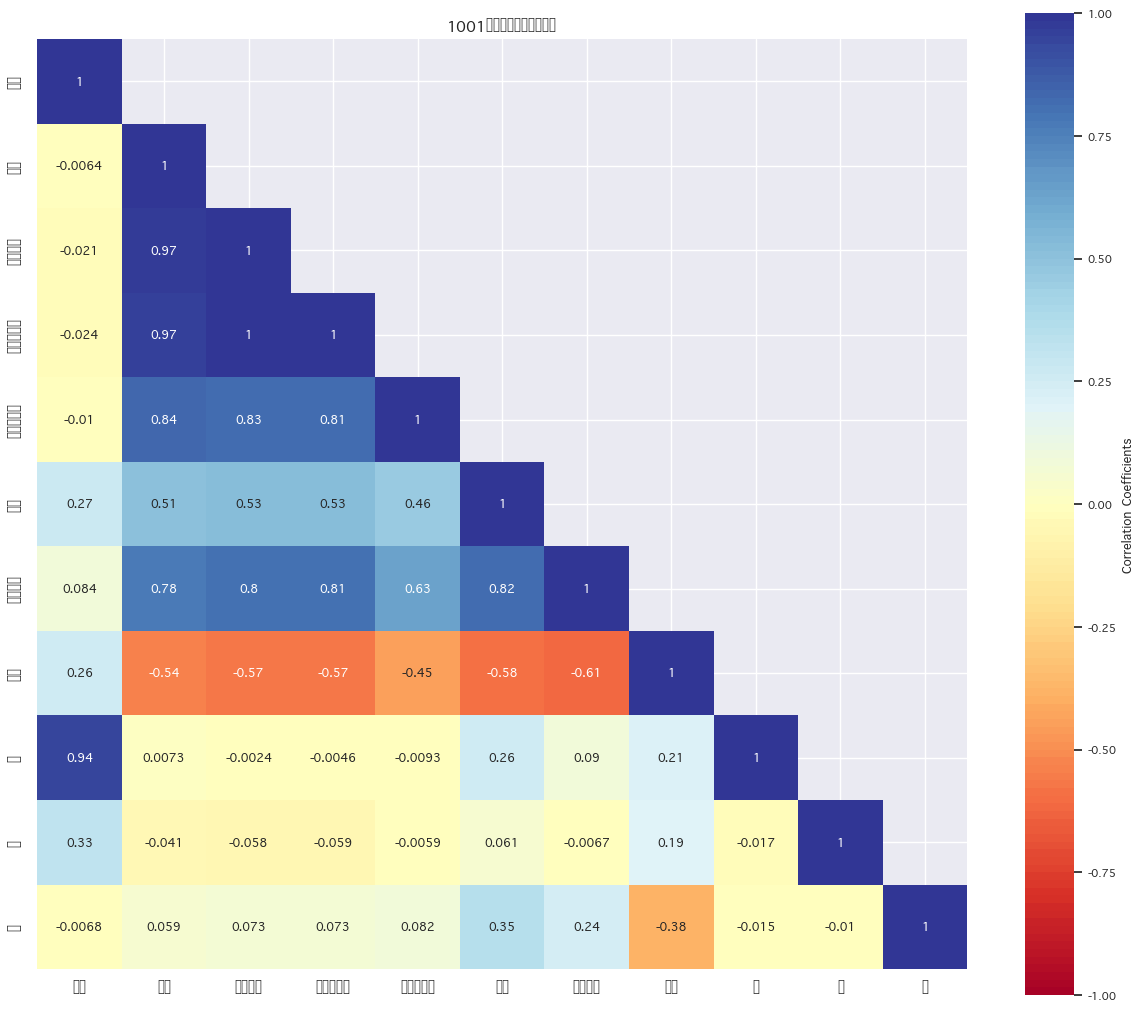

In [18]:
mask = np.array(corrMatrix)
mask[np.tril_indices_from(mask)] = False
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
plt.tick_params(labelsize=15)
sns.heatmap(corrMatrix, mask=mask, cmap = cmaps.MPL_RdYlBu,vmin=-1, vmax=1,
            cbar_kws={'label':'Correlation Coefficients','shrink':0.85}, square=True, annot=True)
plt.title('1001光伏电站特征相关系数', fontsize=15)
plt.savefig('./out/heatmap.jpg',bbox_inches='tight',dpi=600)
plt.show()

In [19]:
data = df[df['光伏电站编号']==1002]
del data['光伏电站编号']
corrMatrix = data.corr()
corrMatrix

,时间,功率,总辐照度,法向辐照度,散射辐照度,气温,光板温度,湿度,月,日,时
时间,1.000000,0.003612,0.005218,0.062862,0.009183,0.386137,-0.083248,0.016462,0.938855,0.318165,-0.003543
功率,0.003612,1.000000,0.942235,0.029446,0.857617,0.560632,-0.035952,-0.630325,0.019110,-0.046015,0.111469
总辐照度,0.005218,0.942235,1.000000,0.010007,0.874647,0.513720,-0.023601,-0.572465,0.020309,-0.043412,0.076875
法向辐照度,0.062862,0.029446,0.010007,1.000000,0.023380,-0.107271,0.012416,0.174408,0.031648,0.093564,0.001146
散射辐照度,0.009183,0.857617,0.874647,0.023380,1.000000,0.506695,-0.044527,-0.564334,0.021384,-0.035589,0.099488
气温,0.386137,0.560632,0.513720,-0.107271,0.506695,1.000000,-0.034060,-0.732924,0.353519,0.141130,0.316271
光板温度,-0.083248,-0.035952,-0.023601,0.012416,-0.044527,-0.034060,1.000000,-0.105097,-0.075294,-0.037420,0.059028
湿度,0.016462,-0.630325,-0.572465,0.174408,-0.564334,-0.732924,-0.105097,1.000000,-0.005949,0.078343,-0.389496
月,0.938855,0.019110,0.020309,0.031648,0.021384,0.353519,-0.075294,-0.005949,1.000000,-0.027398,-0.011766
日,0.318165,-0.046015,-0.043412,0.093564,-0.035589,0.141130,-0.037420,0.078343,-0.027398,1.000000,-0.009840


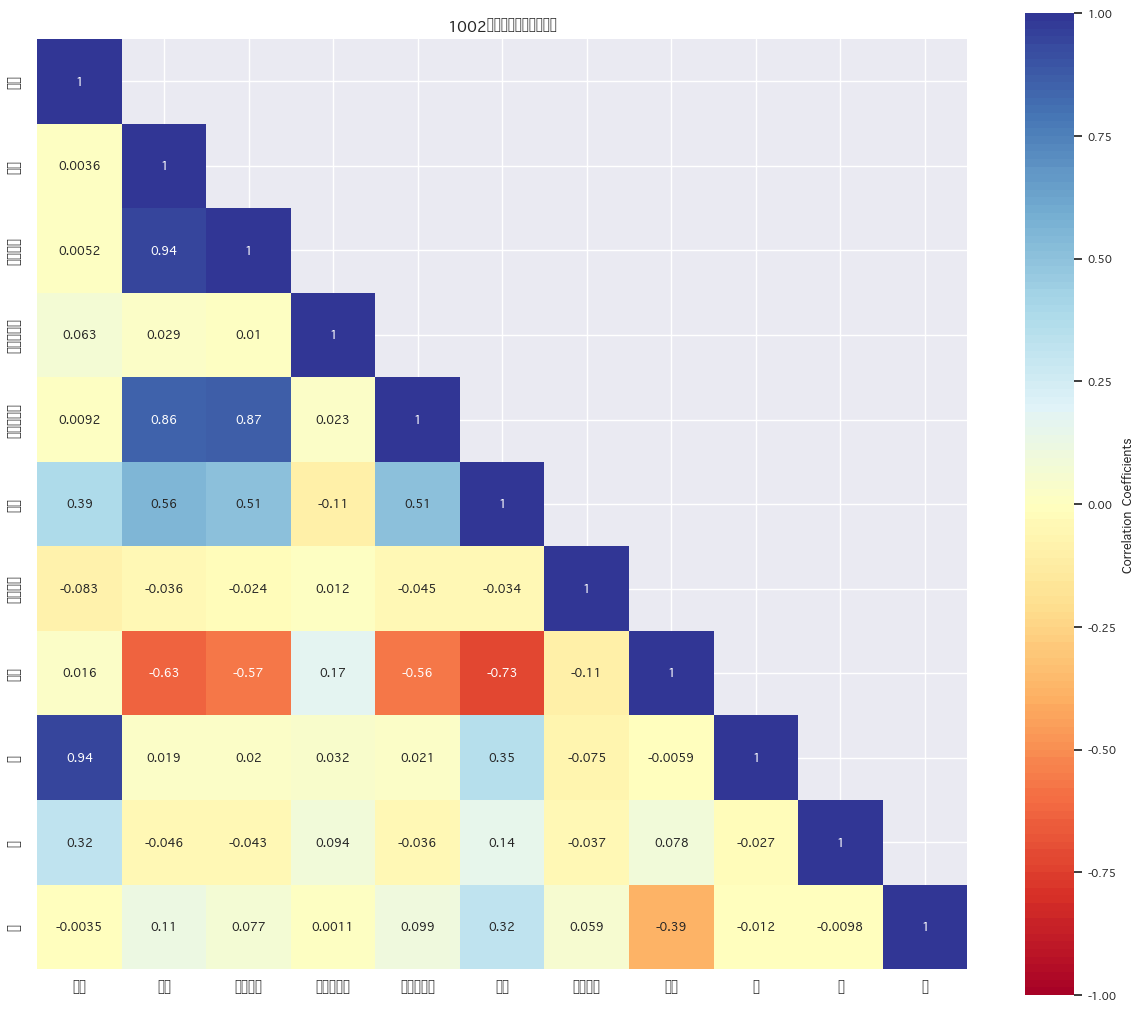

In [20]:
mask = np.array(corrMatrix)
mask[np.tril_indices_from(mask)] = False
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
plt.tick_params(labelsize=15)
sns.heatmap(corrMatrix, mask=mask, cmap = cmaps.MPL_RdYlBu, vmin=-1, vmax=1,
            cbar_kws={'label':'Correlation Coefficients','shrink':0.85}, square=True, annot=True)
plt.title('1002光伏电站特征相关系数', fontsize=15)
plt.show()

In [21]:

# 确定变量：总辐照度、散射辐照度、气温、湿度、月、日、时
data = df.loc[:,['光伏电站编号','总辐照度','散射辐照度','气温','湿度','月','日','时','功率']]
data1 = data[data['光伏电站编号']==1001].reset_index(drop=True)
data2 = data[data['光伏电站编号']==1002].reset_index(drop=True)

# 确定时间提前量：前3个小时（仅总辐照度、散射辐照度、气温、湿度和功率5个变量）
data1_step1 = data1.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(1)
data1_step1.rename(columns = {'总辐照度':'总辐照度_1','散射辐照度':'散射辐照度_1','气温':'气温_1','湿度':'湿度_1','功率':'功率_1'}, inplace=True)
data1_step2 = data1.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(2)
data1_step2.rename(columns = {'总辐照度':'总辐照度_2','散射辐照度':'散射辐照度_2','气温':'气温_2','湿度':'湿度_2','功率':'功率_2'}, inplace=True)
data1_step3 = data1.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(3)
data1_step3.rename(columns = {'总辐照度':'总辐照度_3','散射辐照度':'散射辐照度_3','气温':'气温_3','湿度':'湿度_3','功率':'功率_3'}, inplace=True)

data1_now = data1.loc[:,['总辐照度','散射辐照度','气温','湿度','月','日','时','功率']]

data1_all = pd.concat([data1_step1, data1_step2, data1_step3, data1_now],axis=1)
data1_all.dropna(axis=0,inplace=True)
data1_all.reset_index(drop=True)
data1_all.insert(0, 'id', 1)

data2_step1 = data2.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(1)
data2_step1.rename(columns = {'总辐照度':'总辐照度_1','散射辐照度':'散射辐照度_1','气温':'气温_1','湿度':'湿度_1','功率':'功率_1'}, inplace=True)
data2_step2 = data2.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(2)
data2_step2.rename(columns = {'总辐照度':'总辐照度_2','散射辐照度':'散射辐照度_2','气温':'气温_2','湿度':'湿度_2','功率':'功率_2'}, inplace=True)
data2_step3 = data2.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(3)
data2_step3.rename(columns = {'总辐照度':'总辐照度_3','散射辐照度':'散射辐照度_3','气温':'气温_3','湿度':'湿度_3','功率':'功率_3'}, inplace=True)

data2_now = data2.loc[:,['总辐照度','散射辐照度','气温','湿度','月','日','时','功率']]

data2_all = pd.concat([data2_step1, data2_step2, data2_step3, data2_now],axis=1)
data2_all.dropna(axis=0,inplace=True)
data2_all.reset_index(drop=True)
data2_all.insert(0, 'id', 2)

data = pd.concat([data1_all, data2_all])


In [22]:
X = data.iloc[:,0:23]
y = data.iloc[:,23]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2022)



In [23]:
# 读取测试集
df_test = pd.read_excel('Prediction_data.xlsx',1)
df_test['月'] = df_test['时间'].dt.month
df_test['日'] = df_test['时间'].dt.day
df_test['时'] = df_test['时间'].dt.hour 
del df_test['气象站编号']
df_test1 = df_test[df_test['光伏电站编号']==1001].loc[:,['光伏电站编号','总辐照度','散射辐照度','气温','湿度','月','日','时','功率']]
df_test2 = df_test[df_test['光伏电站编号']==1002].loc[:,['光伏电站编号','总辐照度','散射辐照度','气温','湿度','月','日','时','功率']]
df_test1_all = pd.concat([data1, df_test1]).reset_index(drop=True)
df_test2_all = pd.concat([data2, df_test2]).reset_index(drop=True)


In [24]:
# 确定时间提前量：前3个小时（仅总辐照度、散射辐照度、气温、湿度4个变量）
data1_step1 = df_test1_all.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(1)
data1_step1.rename(columns = {'总辐照度':'总辐照度_1','散射辐照度':'散射辐照度_1','气温':'气温_1','湿度':'湿度_1','功率':'功率_1'}, inplace=True)
data1_step2 = df_test1_all.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(2)
data1_step2.rename(columns = {'总辐照度':'总辐照度_2','散射辐照度':'散射辐照度_2','气温':'气温_2','湿度':'湿度_2','功率':'功率_2'}, inplace=True)
data1_step3 = df_test1_all.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(3)
data1_step3.rename(columns = {'总辐照度':'总辐照度_3','散射辐照度':'散射辐照度_3','气温':'气温_3','湿度':'湿度_3','功率':'功率_3'}, inplace=True)

data1_now = df_test1_all.loc[:,['总辐照度','散射辐照度','气温','湿度','月','日','时','功率']]

data1_all = pd.concat([data1_step1, data1_step2, data1_step3, data1_now],axis=1)
data1_all.reset_index(drop=True)
data1_all.insert(0, 'id', 1)
data1_all.iloc[-4:,:]

,id,总辐照度_1,散射辐照度_1,气温_1,湿度_1,功率_1,总辐照度_2,散射辐照度_2,气温_2,湿度_2,...,湿度_3,功率_3,总辐照度,散射辐照度,气温,湿度,月,日,时,功率
2025,1,553.43,104.50,29.36,69.30,868.1048,848.17,145.34,28.71,73.81,...,80.92,696.0859,813.63,93.44,29.27,69.14,8,30,14,NaN
2026,1,813.63,93.44,29.27,69.14,NaN,553.43,104.50,29.36,69.30,...,73.81,854.3264,676.27,70.04,29.31,61.19,8,30,15,NaN
2027,1,676.27,70.04,29.31,61.19,NaN,813.63,93.44,29.27,69.14,...,69.30,868.1048,542.49,60.32,28.72,58.79,8,30,16,NaN
2028,1,542.49,60.32,28.72,58.79,NaN,676.27,70.04,29.31,61.19,...,69.14,NaN,104.92,27.77,27.96,63.02,8,30,17,NaN


In [25]:
data2_step1 = df_test2_all.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(1)
data2_step1.rename(columns = {'总辐照度':'总辐照度_1','散射辐照度':'散射辐照度_1','气温':'气温_1','湿度':'湿度_1','功率':'功率_1'}, inplace=True)
data2_step2 = df_test2_all.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(2)
data2_step2.rename(columns = {'总辐照度':'总辐照度_2','散射辐照度':'散射辐照度_2','气温':'气温_2','湿度':'湿度_2','功率':'功率_2'}, inplace=True)
data2_step3 = df_test2_all.loc[:,['总辐照度','散射辐照度','气温','湿度','功率']].shift(3)
data2_step3.rename(columns = {'总辐照度':'总辐照度_3','散射辐照度':'散射辐照度_3','气温':'气温_3','湿度':'湿度_3','功率':'功率_3'}, inplace=True)

data2_now = df_test2_all.loc[:,['总辐照度','散射辐照度','气温','湿度','月','日','时','功率']]

data2_all = pd.concat([data2_step1, data2_step2, data2_step3, data2_now],axis=1)
data2_all.reset_index(drop=True)
data2_all.insert(0, 'id', 2)
data2_all.iloc[-4:,:]

,id,总辐照度_1,散射辐照度_1,气温_1,湿度_1,功率_1,总辐照度_2,散射辐照度_2,气温_2,湿度_2,...,湿度_3,功率_3,总辐照度,散射辐照度,气温,湿度,月,日,时,功率
1948,2,98.0,120.0,30.3,70.6,583.5537,638.0,549.0,29.3,75.8,...,78.2,482.3173,324.0,322.0,29.5,73.9,8,30,14,NaN
1949,2,324.0,322.0,29.5,73.9,NaN,98.0,120.0,30.3,70.6,...,75.8,604.1481,370.0,446.0,30.7,66.7,8,30,15,NaN
1950,2,370.0,446.0,30.7,66.7,NaN,324.0,322.0,29.5,73.9,...,70.6,583.5537,115.0,145.0,31.1,68.2,8,30,16,NaN
1951,2,115.0,145.0,31.1,68.2,NaN,370.0,446.0,30.7,66.7,...,73.9,NaN,41.0,50.0,30.1,72.0,8,30,17,NaN


In [26]:
# 构建随机森林回归模型

def process_data_with_randomness(X,y,test_data):   
    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2022)
    # reg = RandomForestRegressor(random_state=2022)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25)
    reg = RandomForestRegressor()
    reg.fit(X_train, y_train)
    
    # 合并测试集
    
    # 进行预测，由于需要用到过去的功率数据，需要将上一个时刻预测结果作为输入数据，进行下一个时刻的预测
    y_pred1_1 = reg.predict(test_data.iloc[0:1,0:23])
    test_data.loc[1:2,['功率_1']] = y_pred1_1
    y_pred1_2 = reg.predict(test_data.iloc[1:2,0:23])
    test_data.loc[2:3,['功率_1']] = y_pred1_2
    test_data.loc[2:3,['功率_2']] = y_pred1_1
    y_pred1_3 = reg.predict(test_data.iloc[2:3,0:23])
    test_data.loc[3:4,['功率_1']] = y_pred1_3
    test_data.loc[3:4,['功率_2']] = y_pred1_2
    test_data.loc[3:4,['功率_3']] = y_pred1_1
    y_pred1_4 = reg.predict(test_data.iloc[3:4,0:23])
    
    y_pred2_1 = reg.predict(test_data.iloc[4:5,0:23])
    test_data.loc[5:6,['功率_1']] = y_pred2_1
    y_pred2_2 = reg.predict(test_data.iloc[5:6,0:23])
    test_data.loc[6:7,['功率_1']] = y_pred2_2
    test_data.loc[6:7,['功率_2']] = y_pred2_1
    y_pred2_3 = reg.predict(test_data.iloc[6:7,0:23])
    test_data.loc[7:8,['功率_1']] = y_pred2_3
    test_data.loc[7:8,['功率_2']] = y_pred2_2
    test_data.loc[7:8,['功率_3']] = y_pred2_1
    y_pred2_4 = reg.predict(test_data.iloc[7:8,0:23])
    
    # 预测数据
    y_pred = np.concatenate([y_pred1_1, y_pred1_2, y_pred1_3, y_pred1_4, y_pred2_1, y_pred2_2, y_pred2_3, y_pred2_4])
    return y_pred


# 收集所有的 processed_values
all_processed_values = []
X = data.iloc[:,0:23]
y = data.iloc[:,23]
test_data = pd.concat([data1_all.iloc[-4:,:], data2_all.iloc[-4:,:]]).reset_index(drop=True)

# 运行过程 1000 次并存储结果
for i in range(1, 1001):
    print(i)
    processed_values = process_data_with_randomness(X,y,test_data)
    all_processed_values.append(pd.Series(processed_values, name=f'Out{i}'))


# 将所有列一次性连接到 results_df 中
results_df = pd.concat(all_processed_values, axis=1)

# 检查结果
# print(results_df)
results_df.head()
results_df.to_csv("./out/outputs1000.csv")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 